### Notebook au propre: fusion des données + reg

In [346]:
#environnement


import pandas as pd

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime
import os

### Formattage données:

Les facteurs sont ceux du début du mois

Les données éco/politiques datent du début du mois ou de la fin du mois précédent



### Evenements politiques

In [347]:
#on code une listd d'événements dont on souhaite étudier l'éffet sur nos séries

events_names=["COV-19", "Ukraine", "Crise-EU", "Macron 1", "Macron 2", "Dissol", "Gilets Jaunes"]
events_dates=["2020-03-01", "2022-02-01", "2011-07-01", "2017-05-01", "2022-06-01", "2023-07-01", "2018-11-01"]
events_dates = pd.to_datetime(events_dates)
events_series = pd.Series(events_names, index=events_dates)

# dates_regdata_all_diff= regdata_all_diff.index
# dates_regdata_all_diff = pd.to_datetime(dates_regdata_all_diff)
# dummys_events= pd.DataFrame(index=dates_regdata_all_diff, columns=events_names)

# regdata_all_diff_dummys = regdata_all_diff.copy()


# for i, col in enumerate(dummys_events.columns):
#     dummys_events[col] = 0
#     #all dates before the event are set to 0
    
#     #all dates after the event are set to 1
#     dummys_events.loc[events_series[col]<=dummys_events.index, col] = 1
events_series



2020-03-01           COV-19
2022-02-01          Ukraine
2011-07-01         Crise-EU
2017-05-01         Macron 1
2022-06-01         Macron 2
2023-07-01           Dissol
2018-11-01    Gilets Jaunes
dtype: object

### Etude des données de Nick Bloom

In [348]:
###Récupérer données Nick Bloom:

# Load the Excel file
file_path = 'data_regression/Europe_Policy_Uncertainty_Data (1).xlsx'
data_NB = pd.read_excel(file_path, engine='openpyxl')

# Drop the last line of the data
data_NB = data_NB[:-1]


# ON affecte la valeur du mois M au premier jour du mois M+1:
data_NB['Date'] = pd.to_datetime(data_NB[['Year', 'Month']].assign(DAY=1)) + pd.offsets.MonthBegin(1)


data_NB.set_index('Date', inplace=True)

#on extrait les données françaises qui nous intéressent:
data_pol_FR = data_NB[["France_News_Index"]]
data_pol_FR.rename(columns={"France_News_Index": "pol_FR"}, inplace=True)

print("Données NB France")
print(data_pol_FR.head())
print(data_pol_FR.index)


Données NB France
               pol_FR
Date                 
1987-02-01  69.958344
1987-03-01  60.321317
1987-04-01  97.610264
1987-05-01  77.494097
1987-06-01  58.174767
DatetimeIndex(['1987-02-01', '1987-03-01', '1987-04-01', '1987-05-01',
               '1987-06-01', '1987-07-01', '1987-08-01', '1987-09-01',
               '1987-10-01', '1987-11-01',
               ...
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',
               '2025-01-01', '2025-02-01'],
              dtype='datetime64[ns]', name='Date', length=457, freq=None)


C:\Users\mathi\AppData\Local\Temp\ipykernel_9992\3670044262.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pol_FR.rename(columns={"France_News_Index": "pol_FR"}, inplace=True)


Maintenant qu'on a récupéré les données mesurant l'instabilité politique, on étudie la stationnarité et l'autocorrélation de la série temporelle à partir de 2010 (dates des autres variables:
Min date: 2010-04-01 00:00:00
Max date: 2024-12-01 00:00:00).


On obtient des données peu autocorrélées pour la France (0.55), pour laquelle on peut rejetter l'hypothèse de non stationarité avec une grande confiance. Pas besoin donc ici de prendre les différences premières.

On ajoute quand mêmes les différences au cas où:

In [349]:
#calcul de l'autoccorrélation des données de Nick Bloom

data_pol_FR_copy = data_pol_FR[data_NB.index >=np.datetime64("2010-01-01")].copy()
# Calculate and print autocorrelation of data_pol_FR_copy
autocorrelation = data_pol_FR_copy["pol_FR"].autocorr()

print("Autocorrelation of data_pol_FR_copy:")
print(autocorrelation)

Autocorrelation of data_pol_FR_copy:
0.5616690564452202


In [350]:
#étude de la stationnarité des données de Nick Bloom

# Conduct a test of stationarity on the data_pol_FR_copy series
from statsmodels.tsa.stattools import adfuller

print("Testing stationarity for data_pol_FR_copy:")
result = adfuller(data_pol_FR_copy)
print(f"p-value: {result[1]}")
print("-" * 50)


Testing stationarity for data_pol_FR_copy:
p-value: 3.847178141057606e-09
--------------------------------------------------


In [351]:
#On calcule l'indice de NB différencié

data_pol_FR["pol_FR_diff"]= data_pol_FR["pol_FR"].diff()
print(data_pol_FR.head())

               pol_FR  pol_FR_diff
Date                              
1987-02-01  69.958344          NaN
1987-03-01  60.321317    -9.637027
1987-04-01  97.610264    37.288947
1987-05-01  77.494097   -20.116167
1987-06-01  58.174767   -19.319329


C:\Users\mathi\AppData\Local\Temp\ipykernel_9992\2849928925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pol_FR["pol_FR_diff"]= data_pol_FR["pol_FR"].diff()


### Indice parlementaire "maison"

             parl_FR  interpolated
date                              
2012-07-31  1.250000         False
2012-08-31  1.000000         False
2012-09-30  2.000000         False
2012-10-31  1.375000         False
2012-11-30  1.777778         False


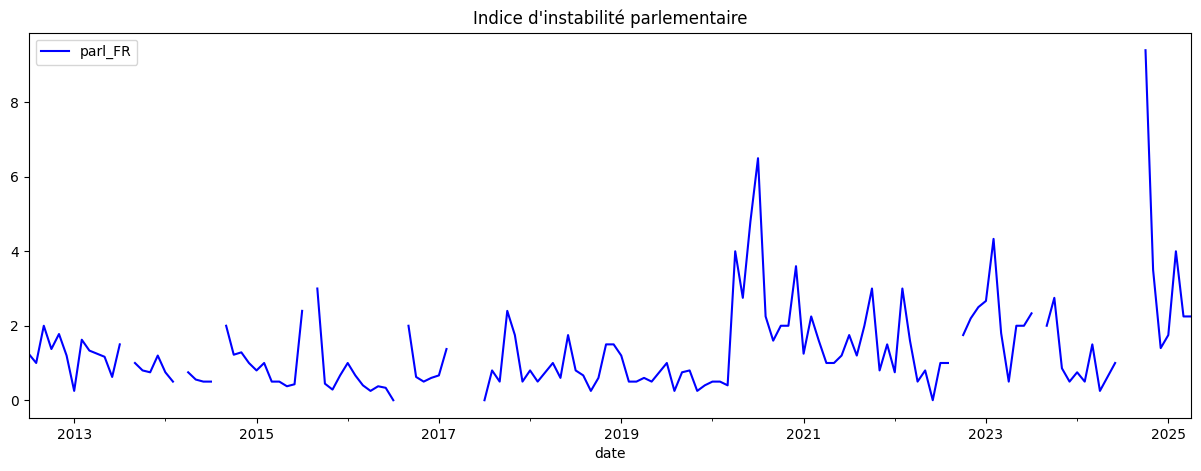

In [352]:
data_parliament = pd.read_csv("data_regression/instability_index.csv", sep=",")
data_parliament.set_index("date", inplace=True)
data_parliament.index = pd.to_datetime(data_parliament.index)
data_parliament.drop(columns=["total_keywords_count","question_count"], inplace=True)
data_parliament.rename(columns={"instability_index": "parl_FR"}, inplace=True)
data_parliament['interpolated'] = data_parliament.isna().any(axis=1)
data_parliament.plot(title="Indice d'instabilité parlementaire", figsize=(15, 5), color="blue")
print(data_parliament.head())


In [353]:
#on modifie les données parlementaires pour que les dates soient les mêmes que celles de Nick Bloom: le 1er de chaque mois
data_parliament.index = data_parliament.index + pd.DateOffset(days=1)
print(data_parliament.head())

             parl_FR  interpolated
date                              
2012-08-01  1.250000         False
2012-09-01  1.000000         False
2012-10-01  2.000000         False
2012-11-01  1.375000         False
2012-12-01  1.777778         False


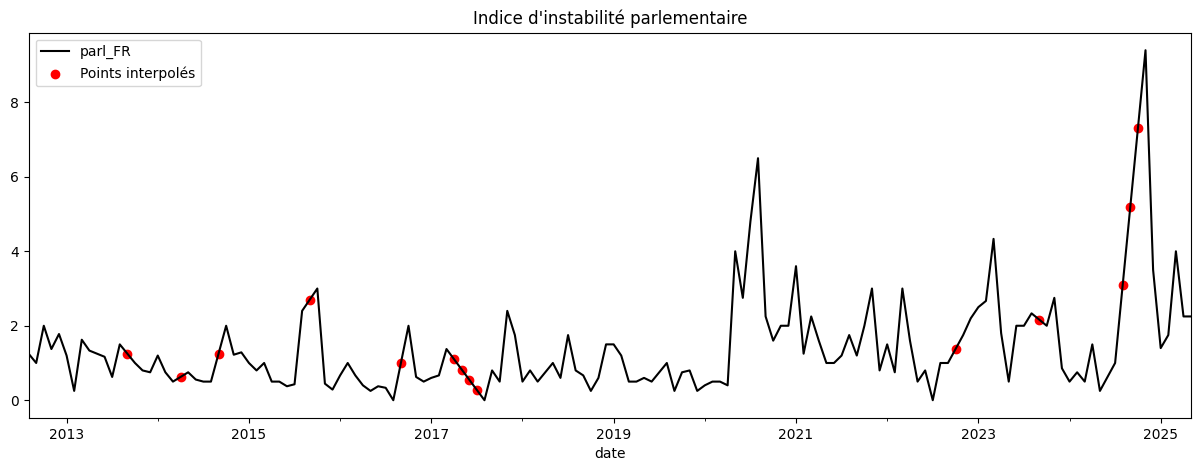

In [354]:
#on interpole les données manquante linéairement:
data_parliament["parl_FR"] = data_parliament["parl_FR"].interpolate(method="linear")

data_parliament["parl_FR"].plot(title="Indice d'instabilité parlementaire", figsize=(15, 5), color="black")
plt.scatter(data_parliament.index[data_parliament['interpolated']], 
            data_parliament["parl_FR"][data_parliament['interpolated']], 
            color='red', label='Points interpolés')
plt.legend()


<Axes: title={'center': "Indice d'instabilité parlementaire"}, xlabel='date'>

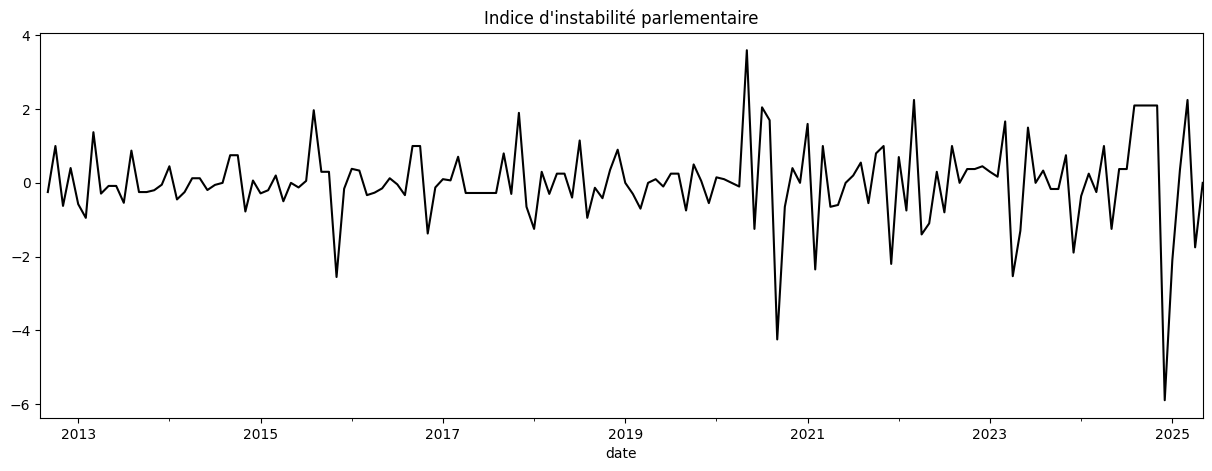

In [355]:
#on rajoute enfin les données différenciées: 

data_parliament["parl_FR_diff"] = data_parliament["parl_FR"].diff()
data_parliament["parl_FR_diff"].plot(title="Indice d'instabilité parlementaire", figsize=(15, 5), color="black")

### Etude des facteurs

Forme des données : (924, 10)
Données hebdo 
            factor 1  factor 2  factor 3  factor 4  factor 5  factor 6  \
Date                                                                     
2007-01-01  0.037039  0.038993  0.037558  0.035665  0.034280  0.033354   
2007-02-01  0.039302  0.039786  0.036896  0.036567  0.036360  0.033583   
2007-03-01  0.039844  0.039838  0.036277  0.035544  0.035338  0.032052   
2007-04-01  0.042372  0.041059  0.036150  0.038201  0.038762  0.031616   
2007-05-01  0.042300  0.042176  0.038850  0.039382  0.039719  0.032401   

            factor 7  factor 8  factor 9  factor 10  factor 1_diff  \
Date                                                                 
2007-01-01  0.032688  0.027748  0.023478   0.029683            NaN   
2007-02-01  0.033681  0.030010  0.023899   0.029864       0.002263   
2007-03-01  0.034416  0.031811  0.023514   0.029110       0.000542   
2007-04-01  0.035432  0.035100  0.023639   0.029535       0.002528   
2007-05-01  0.03

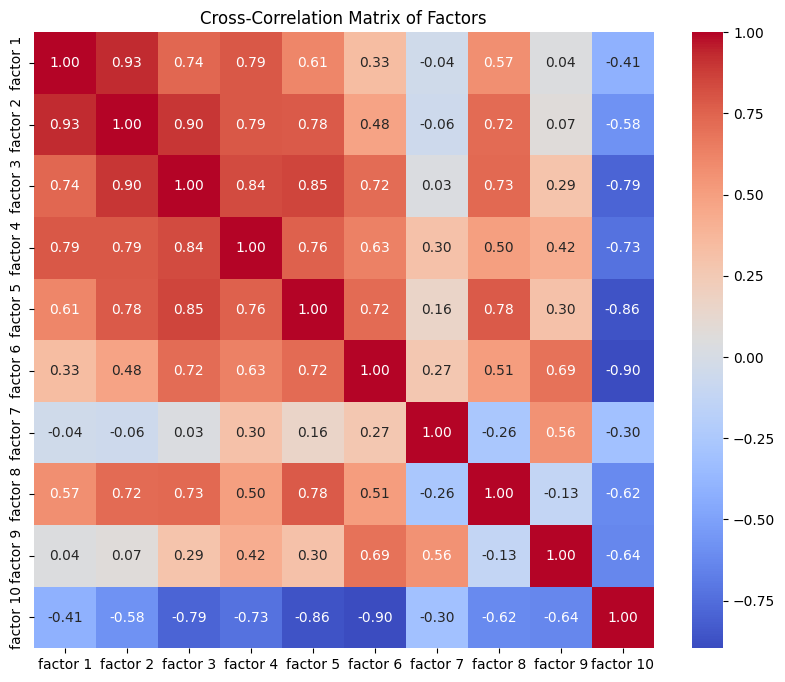

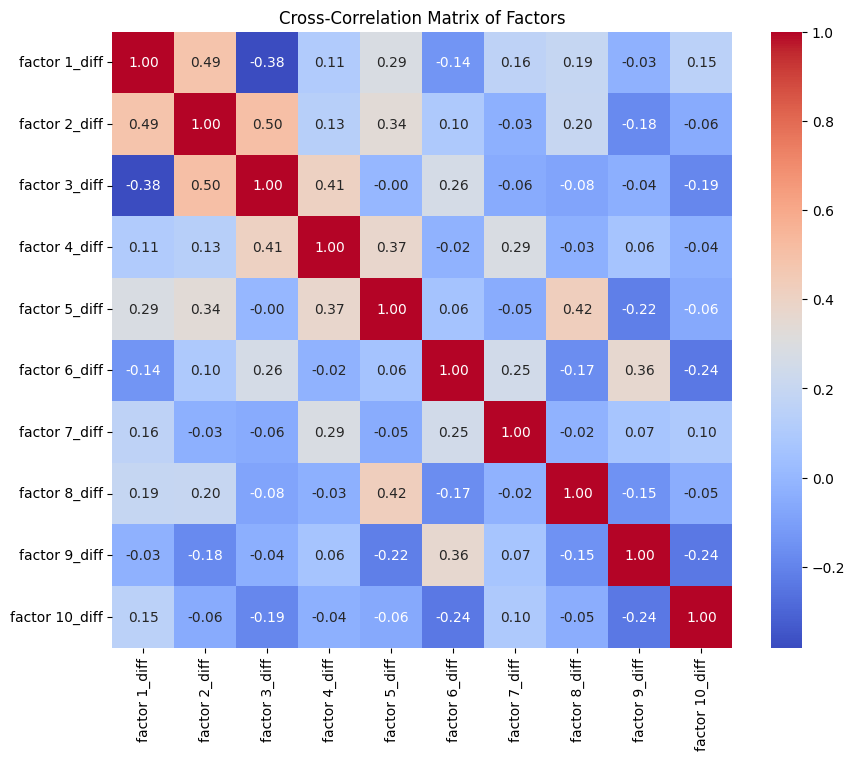

In [356]:
###Récupérer Facteurs:


# Lire les données depuis le fichier texte
array_factors = np.loadtxt('data_regression/mu_dd_CANFCPv2_FS10_31.txt')

# Vérifier la forme des données
print("Forme des données :", array_factors.shape)  # Doit afficher (nombre_de_lignes, 10)

# Créer la variable temps sous forme de dates
start_date = datetime.date(2007, 1, 3)
dates = np.array([start_date + datetime.timedelta(weeks=i) for i in range(array_factors.shape[0])])

# Convertir les dates en indices pour la régression linéaire
temps = np.arange(array_factors.shape[0]).reshape(-1, 1)  # [0, 1, 2, ..., n-1]

data_factors=pd.DataFrame(array_factors)
data_factors['Date']= dates
data_factors['Date']=pd.to_datetime(data_factors['Date'])

data_factors.set_index('Date', inplace=True)

data_factors.columns = [f"factor {i+1}" for i in range(10)]


print("Données hebdo ")
## reindexer pour avoir des facteurs mensuels:

data_factors_mensuel = data_factors.resample('MS').first()

#rajouter les valeurs différenciées des facteurs dans le dataframe:
for i in range(10):
    data_factors_mensuel[f"factor {i+1}_diff"] = data_factors_mensuel[f"factor {i+1}"].diff()
print(data_factors_mensuel.head())


print("Données avec différenciation, mensuelles")
print(data_factors_mensuel.tail())


### Ici on étudie les données utilisées plus tard pour les régressions:

#data_factors_copy2 est utilisé pour étudier les facteurs
#data_factors_mensuel_copy2 = data_factors_mensuel[data_factors_mensuel.index >= np.datetime64("2009-12-01")]

data_factors_mensuel_copy2=data_factors_mensuel.copy()

# Calculate autocorrelation for each factor
autocorrelations = data_factors_mensuel_copy2.apply(lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None)



import seaborn as sns

def corr_matrix(data):
    # Calculate the cross-correlation matrix
    correlation_matrix = data.corr()

    # Plot the cross-correlation matrix of factors
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Cross-Correlation Matrix of Factors")
    plt.show()


corr_matrix(data_factors_mensuel_copy2[[f"factor {i}" for i in range(1,11)]])
corr_matrix(data_factors_mensuel_copy2[[f"factor {i}_diff" for i in range(1,11)]])

Autocorrelation of factors:
factor 1          0.990628
factor 2          0.991032
factor 3          0.971204
factor 4          0.979313
factor 5          0.983506
factor 6          0.988419
factor 7          0.975730
factor 8          0.979264
factor 9          0.988397
factor 10         0.993915
factor 1_diff     0.342674
factor 2_diff     0.430799
factor 3_diff     0.042178
factor 4_diff    -0.043818
factor 5_diff     0.014282
factor 6_diff     0.276924
factor 7_diff     0.055185
factor 8_diff     0.209526
factor 9_diff     0.509120
factor 10_diff    0.533948
dtype: float64


C:\Users\mathi\AppData\Local\Temp\ipykernel_9992\529019364.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


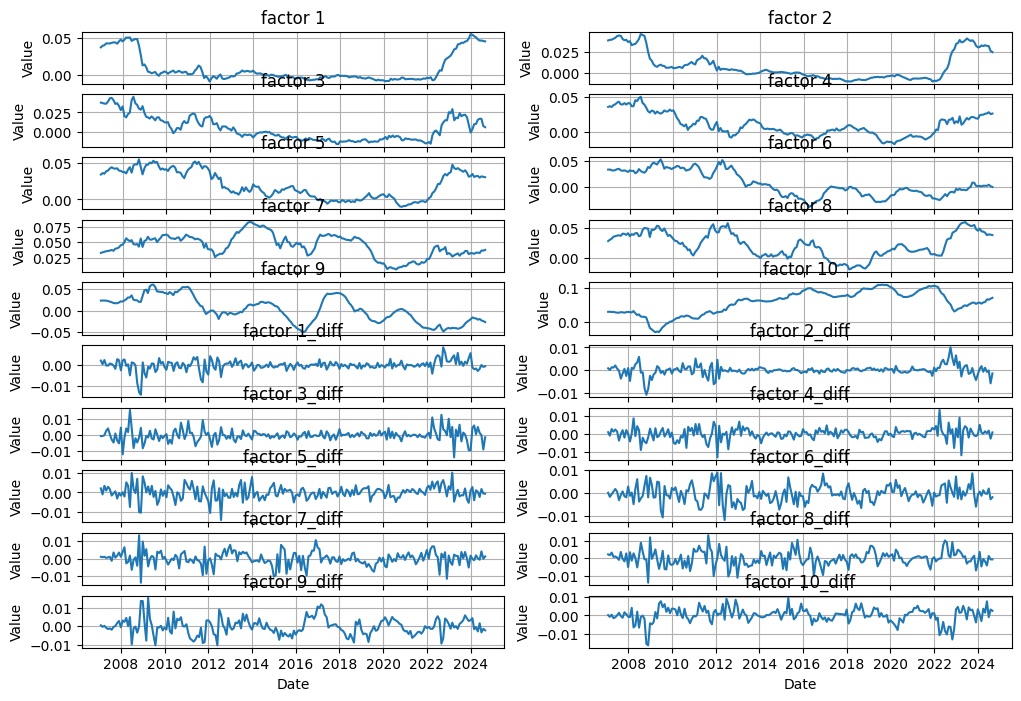

In [357]:
# Calculate autocorrelation for each factor (only numeric columns)
numeric_columns = data_factors_mensuel_copy2.select_dtypes(include=[np.number])
autocorrelations = numeric_columns.apply(lambda col: col.autocorr())

# Print autocorrelation values
print("Autocorrelation of factors:")
print(autocorrelations)


# Plot the factors
plt.figure(figsize=(12, 8))
for i, column in enumerate(data_factors_mensuel_copy2.columns, 1):
    plt.subplot(10, 2, i)
    plt.plot(data_factors_mensuel_copy2[column])
    plt.title(column)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

On teste ensuite la stationarité. On ne peut pas rejeter l'hypothèse de non stationarité pour la grande majorité des facteurs

In [358]:
#conduct a test of stationarity on the factors:
from statsmodels.tsa.stattools import adfuller

for column in data_factors_mensuel_copy2.columns:
    print(f"Testing stationarity for {column}:")
    result = adfuller(data_factors_mensuel_copy2[column].copy().dropna())
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

Testing stationarity for factor 1:
p-value for factor 1: 0.35008850066085734
--------------------------------------------------
Testing stationarity for factor 2:
p-value for factor 2: 0.06404387249148921
--------------------------------------------------
Testing stationarity for factor 3:
p-value for factor 3: 0.134750918656232
--------------------------------------------------
Testing stationarity for factor 4:
p-value for factor 4: 0.32331656664201963
--------------------------------------------------
Testing stationarity for factor 5:
p-value for factor 5: 0.4629234555934969
--------------------------------------------------
Testing stationarity for factor 6:
p-value for factor 6: 0.4259136238281786
--------------------------------------------------
Testing stationarity for factor 7:
p-value for factor 7: 0.19532858204545978
--------------------------------------------------
Testing stationarity for factor 8:
p-value for factor 8: 0.3886714610921149
--------------------------------

In [359]:
#on produit enfin une table qui résume les données de data_factors_diff en indiquant leur autocorrélation et leurs statistique de Dickey Fuller:
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
# Compute summary statistics
summary_factors = data_factors_mensuel.copy()
summary_stats_factors = summary_factors.describe().T

# Add autocorrelation column
summary_stats_factors['autocorrelation'] = summary_factors.apply(
    lambda col: col.dropna().autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Add Dickey-Fuller test p-value column
summary_stats_factors['dickey_fuller_pvalue'] = summary_factors.apply(
    lambda col: adfuller(col.dropna())[1] if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table_factordiff = tabulate(summary_factors, headers="keys", tablefmt="github")

print(summary_stats_factors.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Autocorrelation and Dickey-Fuller Test"))

\begin{table}
\caption{Summary Statistics with Autocorrelation and Dickey-Fuller Test}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & autocorrelation & dickey_fuller_pvalue \\
\midrule
factor 1 & 213.000 & 0.008 & 0.019 & -0.009 & -0.004 & -0.000 & 0.006 & 0.055 & 0.991 & 0.350 \\
factor 2 & 213.000 & 0.008 & 0.017 & -0.010 & -0.005 & 0.002 & 0.015 & 0.047 & 0.991 & 0.064 \\
factor 3 & 213.000 & 0.004 & 0.015 & -0.015 & -0.009 & -0.001 & 0.016 & 0.045 & 0.971 & 0.135 \\
factor 4 & 213.000 & 0.010 & 0.016 & -0.018 & -0.003 & 0.005 & 0.020 & 0.050 & 0.979 & 0.323 \\
factor 5 & 213.000 & 0.020 & 0.019 & -0.010 & 0.003 & 0.015 & 0.039 & 0.055 & 0.984 & 0.463 \\
factor 6 & 213.000 & 0.005 & 0.024 & -0.039 & -0.014 & -0.000 & 0.031 & 0.053 & 0.988 & 0.426 \\
factor 7 & 213.000 & 0.044 & 0.018 & 0.006 & 0.032 & 0.046 & 0.057 & 0.083 & 0.976 & 0.195 \\
factor 8 & 213.000 & 0.022 & 0.021 & -0.020 & 0.006 & 0.021 & 0.038 & 0.060 & 0.979 & 0.389 \\
fac

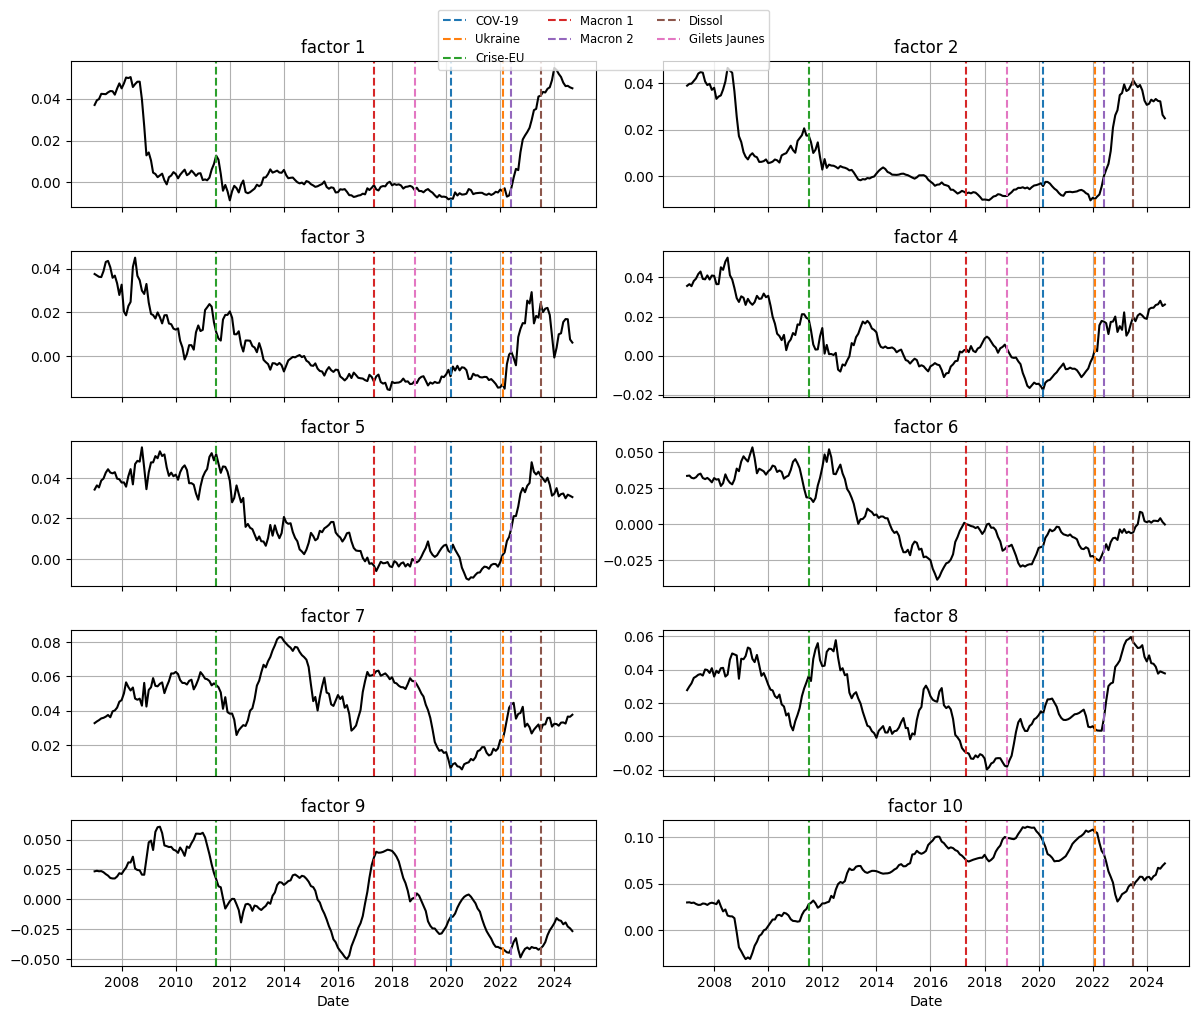

In [360]:
# Plot des facteurs pour le rapport: Figure 2.

#on prend les facteurs mensuels:
data_factors_to_plot = data_factors_mensuel[[f"factor {i+1}" for i in range(10)]]

# plot the factors with the same x-axis for all plots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 10), sharex=True)
axes = axes.flatten()

for i, column in enumerate(data_factors_to_plot.columns):
    axes[i].plot(data_factors_to_plot.index, data_factors_to_plot[column], color='black')
    axes[i].set_title(column)
    axes[i].grid(True)

# Set the x-axis label for the last row of plots
for ax in axes[-2:]:
    ax.set_xlabel("Date")

# Add the events from events_series as vertical lines on all plots
colors = plt.cm.tab10.colors  # Use a colormap for different colors
event_colors = {event_name: colors[i % len(colors)] for i, event_name in enumerate(events_series.values)}

for ax in axes:
    for event_date, event_name in events_series.items():
        ax.axvline(x=event_date, color=event_colors[event_name], linestyle='--')

# Add a legend for the events
handles = [plt.Line2D([0], [0], color=color, linestyle='--', label=event_name) for event_name, color in event_colors.items()]
fig.legend(handles=handles, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.02), fontsize='small')

plt.tight_layout()
plt.show()

### Etude des données macroéconomiques

In [361]:
### Récupérer des données types BCE:

def récup_données_bce(file_path, value_name):
    """
    Cette fonction lit un fichier CSV contenant des données de la BCE et renvoie un DataFrame avec les données pertinentes.
    """
    # Lire le fichier CSV
    data_name = pd.read_csv(file_path)
    print(f"reading {value_name} file")
    
    # Convertir la colonne 'Date' en datetime
    data_name['DATE'] = pd.to_datetime(data_name['DATE'])
    
    # Renommer les colonnes pertinentes
    data_name.columns=['Date',"Time_period",value_name]

    data_name.drop("Time_period", axis=1, inplace=True)

    data_name.set_index('Date', inplace=True)


    
    return data_name


# extraction des données brutes:

file_names = ["20250319150056.csv","inflation_fr.csv","inflationexpect_lt.csv", "euribor3months.csv", "debt_gdp_france.csv"]

list_filepaths= ["data_regression/ECB Data Portal_"+ file for file in file_names]
list_value_names=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr"]

list_BCE_data = [récup_données_bce(list_filepaths[i],list_value_names[i]) for i in range(len(list_filepaths))]

for data in list_BCE_data:
    print(data.head())

reading deposit_rate file
reading infl_fr file
reading infl_for_lt file
reading euribor3 file
reading debt_gdp_fr file
            deposit_rate
Date                    
1999-01-01           NaN
1999-01-04          0.75
1999-01-05          0.75
1999-01-06          0.75
1999-01-07          0.75
            infl_fr
Date               
1997-01-31      1.8
1997-02-28      1.7
1997-03-31      1.1
1997-04-30      1.0
1997-05-31      0.9
            infl_for_lt
Date                   
1999-03-31         1.86
2000-03-31         1.77
2001-03-31         1.81
2001-06-30         1.80
2001-09-30         1.81
            euribor3
Date                
1994-01-31      6.91
1994-02-28      6.86
1994-03-31      6.75
1994-04-30      6.57
1994-05-31      6.24
            debt_gdp_fr
Date                   
1999-03-31       60.228
1999-06-30       59.523
1999-09-30       59.731
1999-12-31       59.062
2000-03-31       60.377


In [362]:
#on ajoute également l'indice du VIX:
data_VIX = pd.read_csv('data_regression/vix-volatility-index-historical-chart.csv', sep=',', parse_dates=['date'], index_col='date')
data_VIX.index = pd.to_datetime(data_VIX.index, format='%Y%m%d')
data_VIX["VIX"]=data_VIX.values
data_VIX = data_VIX.resample('MS').first()
print(data_VIX.head()) #ici, on prend le premier VIX du mois, puisque l'on considère que l'instabilité politique est économique opèrent simutanément


             value    VIX
date                     
1990-01-01   17.24  17.24
1990-02-01   24.87  24.87
1990-03-01   21.90  21.90
1990-04-01   22.84  22.84
1990-05-01   18.43  18.43


In [363]:
#Aligner les dates de départ:
start_date= pd.to_datetime("2005-01-01")
start_date2= pd.to_datetime("2005-02-01")

end_date= pd.to_datetime("2025-03-01")
end_date2=pd.to_datetime("2024-10-01")





### Tout convertir en base mensuelle :
list_BCE_data_copy=[data[data.index>=np.datetime64("2005-01-01")].copy() for data in list_BCE_data]


data_deposit_rate, data_infl_fr, data_infl_for_lt, data_euribor3,data_debt_gdp_fr= list_BCE_data_copy

## Deposit rate: journalier:

data_deposit_rate = data_deposit_rate[data_deposit_rate.index.is_month_start]
data_deposit_rate["deposit_rate"]=data_deposit_rate["deposit_rate"]


## inflation fr: mensuel. Caser 1er du mois suivant --> = inflation observée sur le mois passé.

data_infl_fr.index = data_infl_fr.index + pd.offsets.MonthBegin(1)


##infl_lt: Qs. caser 1er du mois

infl_index= data_infl_for_lt.index
new_infl_index = pd.date_range(start=start_date, end='2025-03-01', freq='3MS')
data_infl_for_lt.index= new_infl_index

new_index2= pd.date_range(start=start_date, end='2025-03-01', freq='MS')

data_infl_for_lt = data_infl_for_lt.reindex(new_index2, method='ffill') #on interpole pas car ce sont les effets d'annonce qui comptent !


## Euribor: mensuel. Caser 1er du mois suivant

data_euribor3.index = data_euribor3.index + pd.offsets.MonthBegin(1)


##debt_gdp: Qs. Caser premier du mois suivant.

gdp_index= data_debt_gdp_fr.index
new_gdp_index = pd.date_range(start="2005-04-01", end="2024-10-01", freq='3MS')
data_debt_gdp_fr.index = new_gdp_index

new_index2= pd.date_range(start='2005-04-01', end='2024-12-01', freq='MS')

data_debt_gdp_fr = data_debt_gdp_fr.reindex(new_index2, method='ffill') #on interpole pas car ce sont les effets d'annonce qui comptent !


##data_VIX : Journaliser, prendre un par mois
data_VIX = data_VIX[data_VIX.index >= start_date].copy()
data_VIX = data_VIX[data_VIX.index <= end_date].copy()



list_BCE_data_reindexed=[data_deposit_rate, data_infl_fr, data_infl_for_lt, data_euribor3,data_debt_gdp_fr, data_VIX]


# for data in list_BCE_data_reindexed:
#     print(data.head())
#     data.drop(columns=["Time_period"], inplace=True)

combined_controls= pd.concat(list_BCE_data_reindexed, axis=1)
combined_controls.columns=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "value","VIX"]
print(combined_controls.head())


            deposit_rate  infl_fr  infl_for_lt  euribor3  debt_gdp_fr  value  \
2005-01-01          -0.5      NaN         1.90       NaN          NaN  14.08   
2005-02-01          -0.5      1.6         1.90    2.1454          NaN  12.03   
2005-03-01          -0.5      1.9         1.90    2.1384          NaN  12.04   
2005-04-01          -0.5      2.1         1.89    2.1372       67.693  14.09   
2005-05-01          -0.5      2.0         1.89    2.1372       67.693  15.12   

              VIX  
2005-01-01  14.08  
2005-02-01  12.03  
2005-03-01  12.04  
2005-04-01  14.09  
2005-05-01  15.12  


C:\Users\mathi\AppData\Local\Temp\ipykernel_9992\1609563167.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_deposit_rate["deposit_rate"]=data_deposit_rate["deposit_rate"]


In [364]:
#keep only the lines that are not empty

combined_controls.dropna(inplace=True)
combined_controls.drop(columns=["value"], inplace=True)
print("Combined controls after dropping 'value' column:")
print(combined_controls.index)
print(len(combined_controls.index))
combined_controls

Combined controls after dropping 'value' column:
DatetimeIndex(['2005-04-01', '2005-05-01', '2005-06-01', '2005-07-01',
               '2005-08-01', '2005-09-01', '2005-10-01', '2005-11-01',
               '2005-12-01', '2006-01-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=237, freq='MS')
237


,deposit_rate,infl_fr,infl_for_lt,euribor3,debt_gdp_fr,VIX
2005-04-01,-0.50,2.1,1.89,2.1372,67.693,14.09
2005-05-01,-0.50,2.0,1.89,2.1372,67.693,15.12
2005-06-01,-0.50,1.7,1.89,2.1256,67.693,12.36
2005-07-01,-0.50,1.8,1.94,2.1110,68.082,11.40
2005-08-01,-0.50,1.8,1.94,2.1194,68.082,12.08
...,...,...,...,...,...,...
2024-08-01,-0.25,2.7,2.02,3.6848,112.435,18.59
2024-09-01,-0.25,2.2,2.02,3.5476,112.435,15.55
2024-10-01,-0.25,1.4,2.01,3.4337,113.828,19.26
2024-11-01,-0.25,1.6,2.01,3.1666,113.828,21.88


On étudie d'abord l'autocorrélation:

In [365]:
#calcul de l'autocorrélation:
autocorrelations = combined_controls.apply(lambda col: col.autocorr() if col.dtype in [np.float64, np.int64] else None)
# Print autocorrelation values
print("Autocorrelation of controls:")
print(autocorrelations)

Autocorrelation of controls:
deposit_rate    0.891257
infl_fr         0.978823
infl_for_lt     0.979237
euribor3        0.996035
debt_gdp_fr     0.997219
VIX             0.770498
dtype: float64


On effectue à nouveau un test de stationarité sur les données de contrôle.

On observe qu'ici aussi, on ne peut rejeter l'hypothèse de non stationarité à 5%

In [366]:
# Test de stationnarité sur les variables de contrôle dans combined_controls:
from statsmodels.tsa.stattools import adfuller

for column in combined_controls.columns:
    print(f"Testing stationarity for {column}:")
    result = adfuller(combined_controls[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

Testing stationarity for deposit_rate:
p-value for deposit_rate: 0.0020464393887133624
--------------------------------------------------
Testing stationarity for infl_fr:
p-value for infl_fr: 0.280714495859008
--------------------------------------------------
Testing stationarity for infl_for_lt:
p-value for infl_for_lt: 0.03203668139538642
--------------------------------------------------
Testing stationarity for euribor3:
p-value for euribor3: 0.21537216095569062
--------------------------------------------------
Testing stationarity for debt_gdp_fr:
p-value for debt_gdp_fr: 0.7508071884200721
--------------------------------------------------
Testing stationarity for VIX:
p-value for VIX: 2.0641092304013107e-06
--------------------------------------------------


On décide donc ici aussi de prendre les 1ères différences

Testing stationarity for deposit_rate after differencing:
p-value for deposit_rate: 3.4155368467126108e-15
--------------------------------------------------
Testing stationarity for infl_fr after differencing:
p-value for infl_fr: 6.450045377837979e-07
--------------------------------------------------
Testing stationarity for infl_for_lt after differencing:
p-value for infl_for_lt: 0.030527981540622688
--------------------------------------------------
Testing stationarity for euribor3 after differencing:
p-value for euribor3: 0.001826984926386111
--------------------------------------------------
Testing stationarity for debt_gdp_fr after differencing:
p-value for debt_gdp_fr: 9.982447790684524e-10
--------------------------------------------------
Testing stationarity for VIX after differencing:
p-value for VIX: 1.428834604551762e-14
--------------------------------------------------


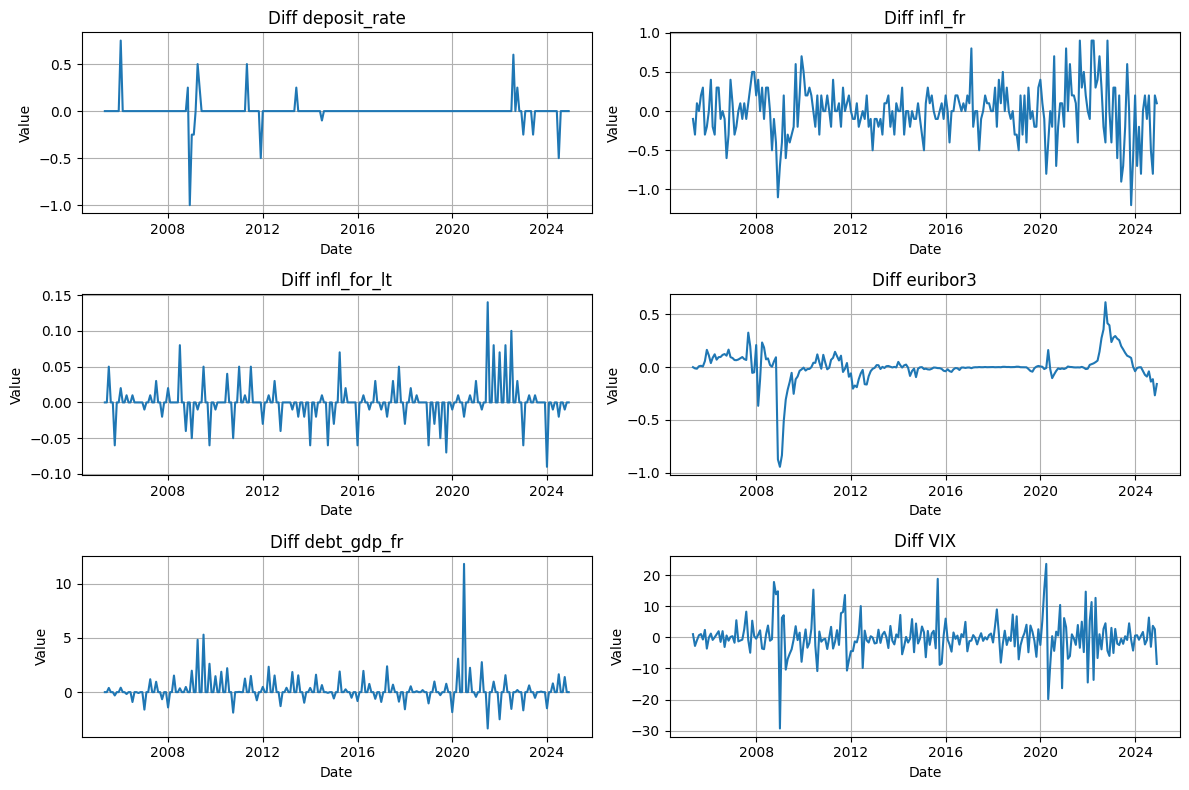

236


In [367]:
# Différencier toutes les colonnes et ajouter les variables différenciées au dataframe
combined_controls_diff = combined_controls.diff().dropna()

# Ajouter les colonnes différenciées au dataframe original
for column in combined_controls_diff.columns:
    combined_controls[f"{column}_diff"] = combined_controls_diff[column]

# Conduct a test of stationarity on each control variable after differencing
for column in combined_controls_diff.columns:
    print(f"Testing stationarity for {column} after differencing:")
    result = adfuller(combined_controls_diff[column])
    print(f"p-value for {column}: {result[1]}")
    print("-" * 50)

# Plot the control variables after differencing
plt.figure(figsize=(12, 8))
for i, column in enumerate(combined_controls_diff.columns, 1):
    plt.subplot((len(combined_controls_diff.columns) + 1) // 2, 2, i)
    plt.plot(combined_controls_diff[column])
    plt.title(f"Diff {column}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

print(len(combined_controls_diff.index))


In [368]:
#On vérifie ensuite si les variables macro  sont autocorrélés:
for column in combined_controls_diff.columns:
    autocorr = combined_controls_diff[column].autocorr()
    print(f"{column}: {autocorr}")

deposit_rate: 0.054551653597000066
infl_fr: 0.1935898084814481
infl_for_lt: -0.0004468219786766617
euribor3: 0.7729002372838204
debt_gdp_fr: -0.02771453239996117
VIX: -0.18656265347857487


In [369]:
#on produit une table de stats descriptives:
 
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
# Compute summary statistics
summary_controls = combined_controls.copy()
summary_stats_controls = summary_controls.describe().T

# Add autocorrelation column
summary_stats_controls['autocorrelation'] = summary_controls.apply(
    lambda col: col.dropna().autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Add Dickey-Fuller test p-value column
summary_stats_controls['dickey_fuller_pvalue'] = summary_controls.apply(
    lambda col: adfuller(col.dropna())[1] if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table_controlsdiff = tabulate(summary_stats_controls, headers="keys", tablefmt="github")

print(summary_stats_controls.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Autocorrelation and Dickey-Fuller Test"))

\begin{table}
\caption{Summary Statistics with Autocorrelation and Dickey-Fuller Test}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & autocorrelation & dickey_fuller_pvalue \\
\midrule
deposit_rate & 237.000 & -0.043 & 0.260 & -1.000 & -0.250 & -0.100 & 0.250 & 0.750 & 0.891 & 0.002 \\
infl_fr & 237.000 & 1.902 & 1.641 & -0.800 & 0.800 & 1.600 & 2.400 & 7.300 & 0.979 & 0.281 \\
infl_for_lt & 237.000 & 1.907 & 0.118 & 1.650 & 1.830 & 1.910 & 1.980 & 2.180 & 0.979 & 0.032 \\
euribor3 & 237.000 & 1.169 & 1.717 & -0.582 & -0.312 & 0.330 & 2.457 & 5.113 & 0.996 & 0.215 \\
debt_gdp_fr & 237.000 & 93.031 & 15.846 & 65.401 & 84.056 & 96.821 & 101.249 & 117.687 & 0.997 & 0.751 \\
VIX & 237.000 & 19.312 & 8.634 & 9.450 & 13.470 & 16.640 & 22.570 & 68.510 & 0.770 & 0.000 \\
deposit_rate_diff & 236.000 & 0.001 & 0.121 & -1.000 & 0.000 & 0.000 & 0.000 & 0.750 & 0.055 & 0.000 \\
infl_fr_diff & 236.000 & -0.002 & 0.338 & -1.200 & -0.200 & 0.000 & 0.200 & 0

On concatène nos données en un dataframe unique

In [370]:
#Attention. Ici les périodes étudiées sont différentes. On ne peut pas concaténer les deux bases de données avant d'avoir fait le ménage dans les dates.

#concatenate factors, controls and pol_data
data_combined = pd.concat([data_factors_mensuel, combined_controls,data_pol_FR, data_parliament[["parl_FR","parl_FR_diff"]]], axis=1)
print(max(data_combined.index))


2025-05-01 00:00:00


### Régression

In [371]:
#on commence par récupérer la période pour laquelle on a des données pour tous les facteurs et les variables de contrôle:
date_range_diff = data_combined.index
mindate = max([min(data_combined[col].dropna().index) for col in data_combined.copy().drop(["parl_FR","parl_FR_diff"], axis=1).columns])
maxdate = min([max(data_combined[col].dropna().index) for col in data_combined.columns])

print("Date range:")
print("Min date:", mindate)
print("Max date:", maxdate)

Date range:
Min date: 2007-02-01 00:00:00
Max date: 2024-09-01 00:00:00


In [372]:
#derniers traitements:

#on normalise pol_FR par 100:
data_combined["pol_FR_diff"] = data_combined["pol_FR_diff"]/100
data_combined["pol_FR"] = data_combined["pol_FR"]/100

#on rescale els facteurs de 100:
for i in range(10):
    data_combined[f"factor {i+1}"] = data_combined[f"factor {i+1}"]*100
    data_combined[f"factor {i+1}_diff"] = data_combined[f"factor {i+1}_diff"]*100

In [ ]:
#on produit une table de stats descriptives:
 
from tabulate import tabulate
from statsmodels.tsa.stattools import adfuller
# Compute summary statistics
summary = data_combined[data_combined.index>=np.datetime64("2010-01-01")].copy()
summary_stats = summary.describe().T

# Add autocorrelation column
summary_stats['autocorrelation'] = summary.apply(
    lambda col: col.dropna().autocorr() if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Add Dickey-Fuller test p-value column
summary_stats['dickey_fuller_pvalue'] = summary_stats.apply(
    lambda col: adfuller(col.dropna())[1] if col.dtype in [np.float64, np.int64] else None, axis=0
)

# Format for markdown or text reports
formatted_table_controlsdiff = tabulate(summary_stats, headers="keys", tablefmt="github")

print(summary_stats.to_latex(index=True, float_format="%.3f", caption="Summary Statistics with Autocorrelation and Dickey-Fuller Test"))



\begin{table}
\caption{Summary Statistics with Autocorrelation and Dickey-Fuller Test}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & 50% & 75% & max & autocorrelation & dickey_fuller_pvalue \\
\midrule
factor 1 & 177.000 & 0.400 & 1.532 & -0.859 & -0.465 & -0.165 & 0.407 & 5.475 & 0.991 & NaN \\
factor 2 & 177.000 & 0.379 & 1.361 & -1.044 & -0.612 & -0.017 & 0.716 & 4.137 & 0.990 & NaN \\
factor 3 & 177.000 & -0.064 & 1.118 & -1.544 & -0.985 & -0.421 & 0.718 & 2.927 & 0.953 & NaN \\
factor 4 & 177.000 & 0.419 & 1.117 & -1.761 & -0.478 & 0.321 & 1.301 & 3.059 & 0.957 & NaN \\
factor 5 & 177.000 & 1.545 & 1.722 & -1.025 & 0.072 & 1.088 & 3.176 & 5.227 & 0.983 & NaN \\
factor 6 & 177.000 & -0.078 & 2.121 & -3.870 & -1.659 & -0.432 & 0.664 & 5.182 & 0.986 & NaN \\
factor 7 & 177.000 & 4.374 & 1.922 & 0.574 & 3.066 & 4.368 & 5.778 & 8.282 & 0.980 & NaN \\
factor 8 & 177.000 & 1.769 & 2.023 & -1.985 & 0.354 & 1.406 & 3.098 & 5.965 & 0.979 & NaN \\
factor 9 & 177.0

Maintenant que nos données sont prêtes, on les visualise une dernière fois avant de régresser


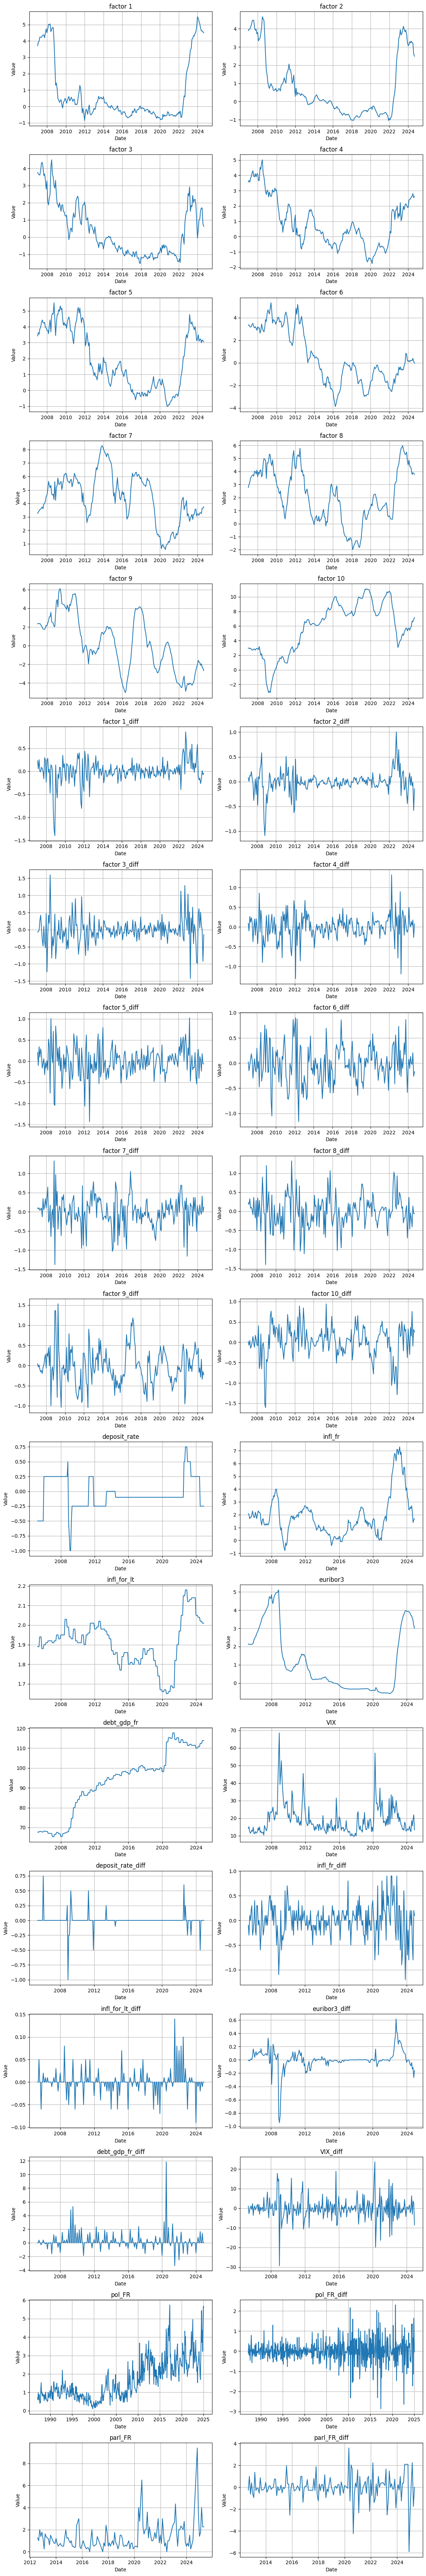

In [374]:
# Plot the data used for the regression

diff = False #plotter les données différenciées ou pas ?

num_columns = len(data_combined.columns)
num_rows = (num_columns + 1) // 2  # Calculate the number of rows needed for 2 columns per row

plt.figure(figsize=(12, 4 * num_rows))  # Adjust figure height based on the number of rows
for i, column in enumerate(data_combined.columns, 1):
    if column[-5:-1] == "_diff" and not diff:
        continue
    plt.subplot(num_rows, 2, i)
    plt.plot(data_combined[column])
    plt.title(str(column))
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
plt.tight_layout()
plt.show()

On étudie enfin les corrélations entre les variables de régression:
- d'abord les facteurs
- ensuite les contrôles pour identifier les contrôles redondants
- enfin le total

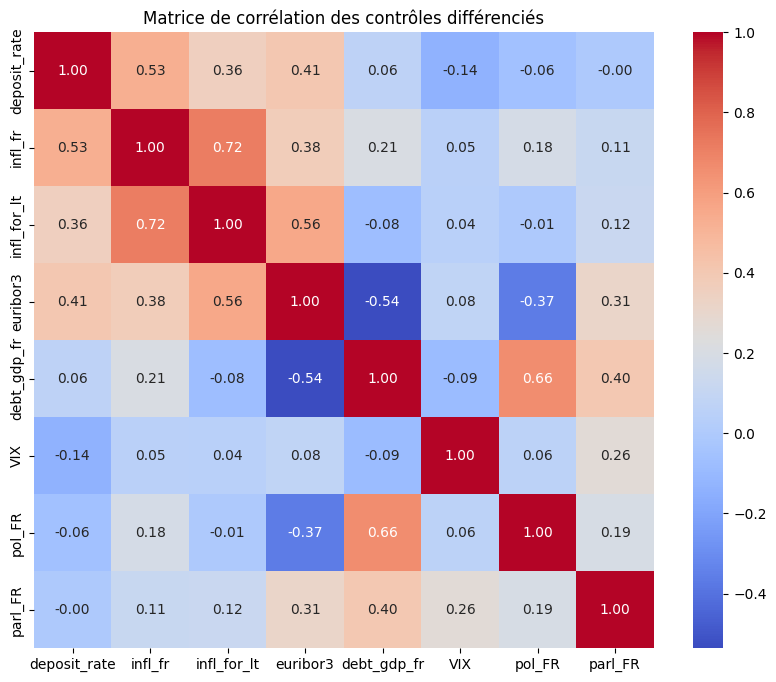

In [375]:
#on s'intéresse  aux correlations entre les contrôles pour limiter la multicolinéarité:

import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_reg = data_combined.copy()[["deposit_rate", "infl_fr", "infl_for_lt", "euribor3", "debt_gdp_fr", "VIX", "pol_FR", "parl_FR"]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix_reg, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des contrôles différenciés")
plt.show()

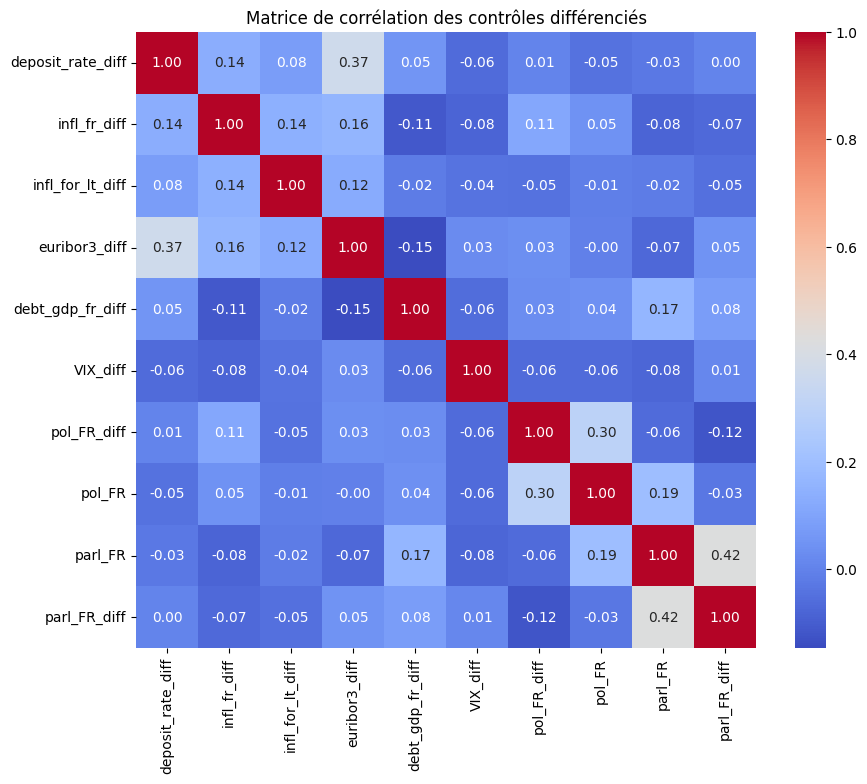

In [376]:
#on jette également un oeil aux corrélation entre les facteurs différentiés

import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_reg = data_combined.copy()[["deposit_rate_diff", "infl_fr_diff", "infl_for_lt_diff", "euribor3_diff", "debt_gdp_fr_diff", "VIX_diff", "pol_FR_diff","pol_FR", "parl_FR", "parl_FR_diff"]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix_reg, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des contrôles différenciés")
plt.show()

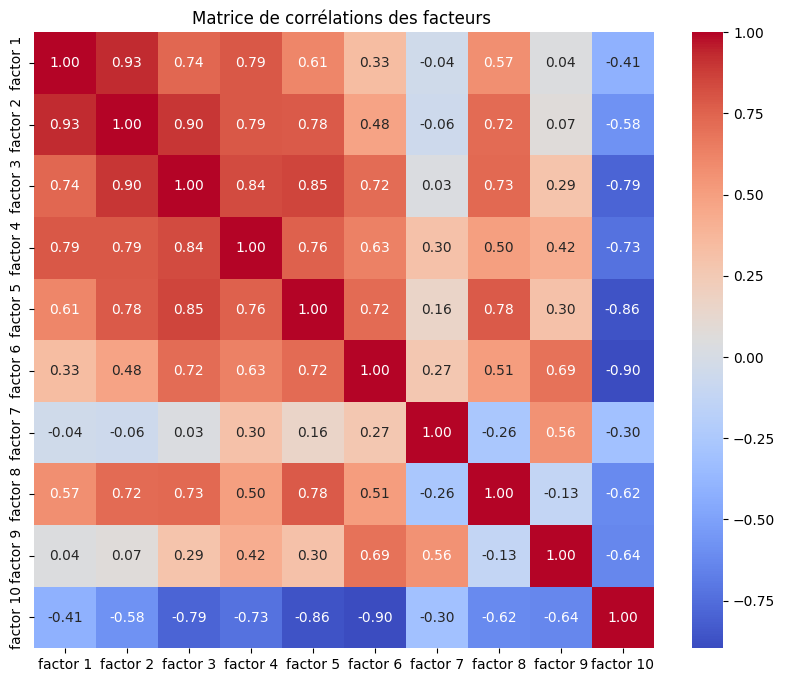

In [377]:
import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_factors = data_combined.copy()[[f"factor {i}" for i in range(1,11)]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_factors, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélations des facteurs ")
plt.show()

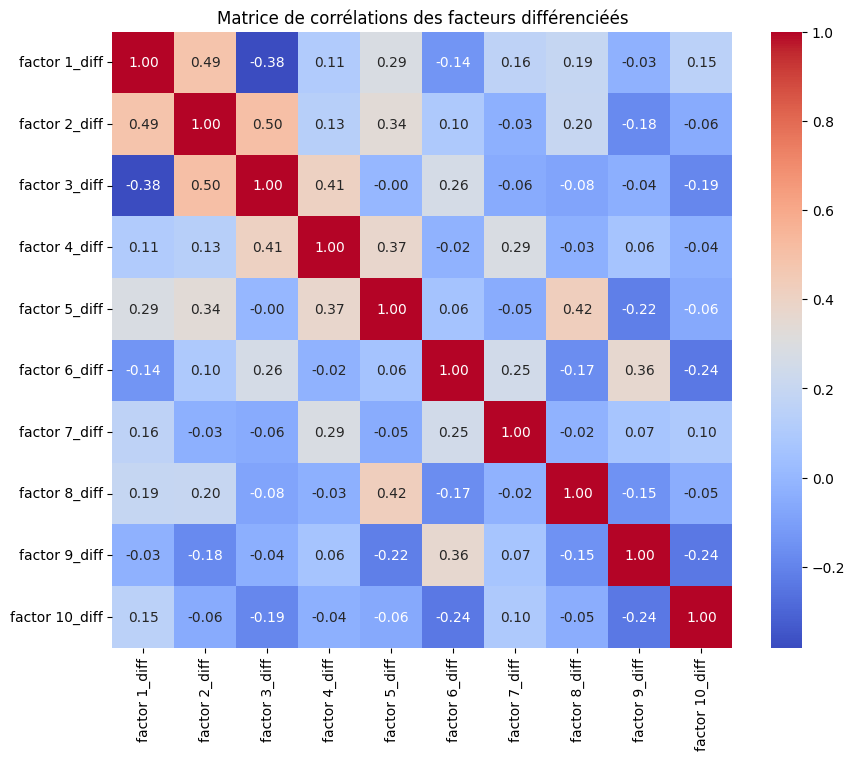

In [378]:
import seaborn as sns
# Calculate the cross-correlation matrix
correlation_matrix_factors_diff = data_combined.copy()[[f"factor {i}_diff" for i in range(1,11)]].corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_factors_diff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélations des facteurs différenciéés")
plt.show()

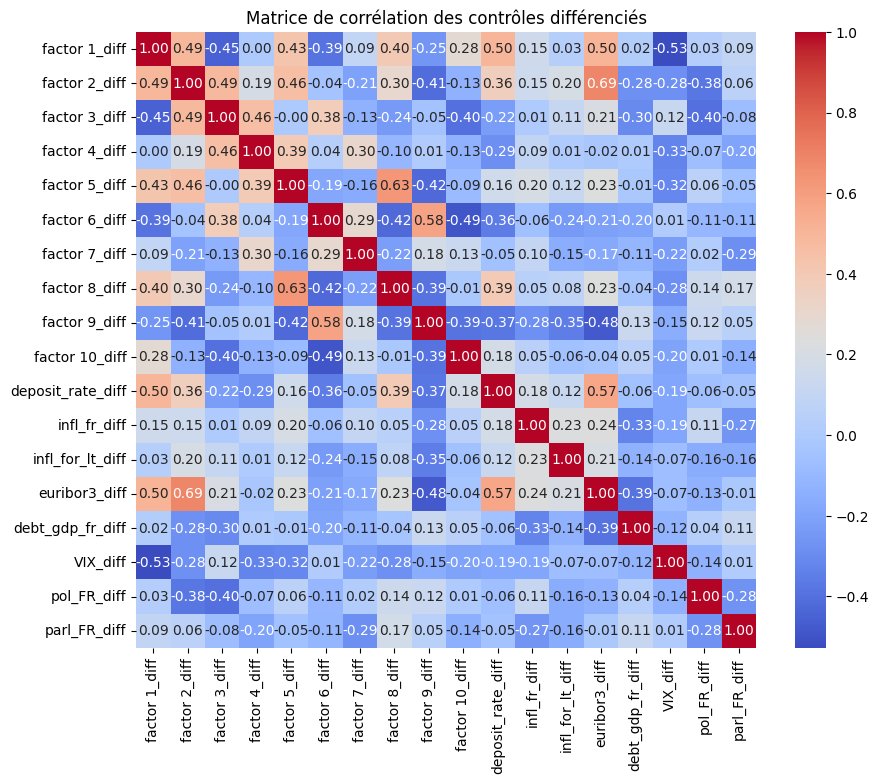

In [379]:
#on s'intéresse  aux correlations entre les contrôles pour limiter la multicolinéarité:
diff = True #plotter les données différenciées ou pas ?

import seaborn as sns
# Calculate the cross-correlation matrix
if diff:
    corr_allvar = data_combined.copy()[[col for col in data_combined.columns if "_diff" in col]].corr()
else:
    corr_allvar = data_combined.copy()[[col for col in data_combined.columns if not "_diff" in col]].corr()
correlation_matrix_regdiff = corr_allvar.corr()

# Plot the cross-correlation matrix of factors
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_regdiff, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de corrélation des contrôles différenciés")
plt.show()

On code enfin les différentes régressions:
- d'abord une régression linéaire simple
- ensuite une régression linéaire prenant en compte l'autocorrélation des erreurs

In [ ]:
from statsmodels.iolib.summary2 import summary_col
import statsmodels.api as sm

def run_model(data, y_var, x_vars, robust=False):
    X = data[x_vars]
    X = sm.add_constant(X)
    Y = data[y_var]
    if robust:
        return sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    else:
        return sm.OLS(Y, X).fit()

    

print_reg=True
save=True

#Choix données:
data_regression = data_combined.copy()

# Choix période: 
mindate_reg= np.datetime64("2010-01-01") 
maxdate_reg=maxdate

data_regression = data_regression[(data_regression.index >= mindate_reg) & (data_regression.index <= maxdate_reg)]

# Spécifications des variables

indep = ["pol_FR"]
indep_diff = ["pol_FR_diff"]

indep_parl=["parl_FR"]
indep_parl_diff=["parl_FR_diff"]

controls = ["deposit_rate", "infl_fr", "infl_for_lt", "euribor3", "debt_gdp_fr", "VIX"]
controls_restreints = ["infl_fr", "infl_for_lt", "euribor3", "debt_gdp_fr", "VIX"]
controls_signif=["infl_fr", "euribor3", "VIX"]

controls_diff = ["deposit_rate_diff", "infl_fr_diff", "infl_for_lt_diff", "euribor3_diff", "debt_gdp_fr_diff", "VIX_diff"]
controls_diff_restreints = ["infl_fr_diff", "infl_for_lt_diff", "euribor3_diff", "debt_gdp_fr_diff", "VIX_diff"]
controls_diff_signif=["infl_fr_diff", "euribor3_diff", "VIX"]

controls_signif_2010=["deposit_rate_diff", "euribor3_diff"]

controls_signif_2007=["deposit_rate_diff","VIX_diff", "euribor3_diff", "debt_gdp_fr_diff"]

controls_signif_2017=["euribor3_diff", "deposit_rate_diff"]
controls_signif_x_diff_2010=["deposit_rate_diff", "euribor3_diff"]


last=["euribor3"]


last2=["infl_fr", "euribor3","VIX"]

# Boucle sur tous les facteurs
models = []
model_names = []

for m in range(19,20): #le faire pour tous les modèles
    models=[]
    print(f"#######################  Régression du modèle {m}: #######################")
    for i in range(10):
        y = f"factor {i+1}"

        y_diff = f"{y}_diff"

        model1 = run_model(data_regression, y, indep, robust=True)
        model2=  run_model(data_regression, y, indep + controls, robust=True)
        model3=  run_model(data_regression, y, indep + controls_signif, robust=True)
        model4 = run_model(data_regression, y_diff, indep, robust=True)
        model5=  run_model(data_regression, y_diff, indep + controls_diff, robust=True)
        model6=  run_model(data_regression, y_diff, indep + controls_diff_signif, robust=True)

        model7 = run_model(data_regression, y_diff, indep_diff, robust=True)
        model8=  run_model(data_regression, y_diff, indep_diff + controls_diff, robust=True)
        model9=  run_model(data_regression, y_diff, indep_diff + controls_diff_signif, robust=True)

        model10= run_model(data_regression.copy().dropna(), y_diff, indep_parl, robust=True)
        model11= run_model(data_regression.copy().dropna(), y_diff, indep_parl + controls_diff, robust=True)
        model12= run_model(data_regression.copy().dropna(), y_diff, indep_parl + controls_diff_signif, robust=True)
        model13= run_model(data_regression.copy().dropna(), y_diff, indep_parl_diff, robust=True)
        model14= run_model(data_regression.copy().dropna(), y_diff, indep_parl_diff + controls_diff, robust=True)
        model15= run_model(data_regression.copy().dropna(), y_diff, indep_parl_diff + controls_diff_signif, robust=True)
        model16= run_model(data_regression.copy().dropna(), y, indep_parl, robust=True)
        model17= run_model(data_regression.copy().dropna(), y, indep_parl+controls_diff, robust=True)
        model18= run_model(data_regression.copy().dropna(), indep, indep_parl, robust=True)
        model19= run_model(data_regression, y_diff, indep+controls_signif_2010, robust=True)
        model20= run_model(data_regression, y_diff, indep+controls_signif_2007, robust=True)
        model21= run_model(data_regression, y_diff, indep+controls_signif_2017, robust=True)
        model22= run_model(data_regression, y_diff, indep_diff+controls_signif_x_diff_2010, robust=True)






        list_models=[model1, model2, model3, model4, model5, model6, model7, 
                     model8, model9, model10, model11, model12, model13, model14, 
                     model15, model16, model17, model18, model19, model20, model21]

        if print_reg:
            print(f"#######################  Regression for factor {i+1}: #######################")
            print(list_models[m-1].summary())

        
        #choix du modèle présenté
        models.append(list_models[m-1])
        model_names.append(f"Facteur {i+1}")

    if save:
        # Création du tableau LaTeX avec 10 colonnes (un facteur par colonne, spécification 5 ici)
        results_table = summary_col(models,
                        stars=True,
                        float_format='%0.3f',
                        model_names=model_names,
                        info_dict={'R²': lambda x: f"{x.rsquared:.2f}",
                            'N': lambda x: f"{int(x.nobs)}"})
        results_table.title = f"Regression Results from {mindate_reg} to {maxdate_reg}"

        # Export LaTeX
        with open(f"table_reg_2010_{m}.tex", "w") as f:
            f.write(results_table.as_latex())


#######################  Régression du modèle 19: #######################
#######################  Regression for factor 1: #######################
                            OLS Regression Results                            
Dep. Variable:          factor 1_diff   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     17.84
Date:                Sun, 20 Apr 2025   Prob (F-statistic):           3.92e-10
Time:                        22:40:12   Log-Likelihood:                 50.589
No. Observations:                 177   AIC:                            -93.18
Df Residuals:                     173   BIC:                            -80.47
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                        coef    std err          z      P>|z| 

### Etude spécifique de l'indice parlementaire

### Tests de l'impact dévénements

Chow test, Bai-Perron...

In [381]:
#on code une listd d'événements dont on souhaite étudier l'éffet sur nos séries

events_names=["COVID-19", "Ukraine War", "Brexit", "Trump Election", "Eurozone Crisis", "Greece Crisis 2", "Macron election 1", "Macron élection 2", "Dissolution", "Gilets Jaunes"]
events_dates=["2020-03-01", "2022-02-01", "2016-06-01", "2016-11-01", "2011-07-01", "2015-07-01", "2017-05-01", "2022-06-01", "2023-07-01", "2018-11-01"]
events_dates = pd.to_datetime(events_dates)
events_series = pd.Series(events_dates, index=events_names)

dates_regdata_all_diff= regdata_all_diff.index
dates_regdata_all_diff = pd.to_datetime(dates_regdata_all_diff)
dummys_events= pd.DataFrame(index=dates_regdata_all_diff, columns=events_names)

regdata_all_diff_dummys = regdata_all_diff.copy()


for i, col in enumerate(dummys_events.columns):
    dummys_events[col] = 0
    #all dates before the event are set to 0
    
    #all dates after the event are set to 1
    dummys_events.loc[events_series[col]<=dummys_events.index, col] = 1

    regdata_all_diff_dummys=pd.concat([regdata_all_diff_dummys, dummys_events], axis=1)



#on ajoute les variables dummies à nos données de régression
regdata_all_diff_dummys = pd.concat([regdata_all_diff.copy(), dummys_events])

controls_events=["deposit_rate", "infl_fr","infl_for_lt","euribor3","debt_gdp_fr", "VIX"]+events_names
independent = ["France_News_Index"]

regdata_all_diff_dummys.tail()

NameError: name 'regdata_all_diff' is not defined

In [ ]:
for i in range(10):
    regression_diff(regdata_all_diff_dummys,i, independent, controls_events,robust=True,)


MissingDataError: exog contains inf or nans